In [1]:
# !pip install spacy
# !python -m spacy download pt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# !ls drive/'My Drive'/mestrado/IA006C/Projeto_Final
# !cp drive/'My Drive'/mestrado/IA006C/Projeto_Final/*.csv .

In [209]:
import re
from unicodedata import normalize
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import spacy
import nltk
from nltk.cluster import KMeansClusterer
from nltk.corpus import stopwords
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import KernelPCA, LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, BatchNormalization, MaxPooling1D, AveragePooling1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
import warnings

warnings.filterwarnings('ignore')
np.random.seed(123456)

%matplotlib inline

def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', "", phrase), disable=["parser"])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != "PUNCT":
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                # clean_frase += [STEMMER.stem(palavra.lemma_)]
                # clean_frase += [STEMMER.stem(palavra.text)]
                # clean_frase += [remover_acentos(palavra.text)]
                clean_frase += [STEMMER.stem(remover_acentos(palavra.lemma_))]
#                 if palavra.pos_ == "VERB":
#                     clean_frase += [remover_acentos(palavra.lemma_)]
#                 else:
#                     clean_frase += [remover_acentos(palavra.text)]
    # return " ".join(clean_frase)
    return clean_frase

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

NLP = spacy.load("pt")
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

In [210]:
df_data1 = pd.read_csv("intents.csv", sep=';', names=["cluster", "perguntas"])
df_data2 = pd.read_csv("ground_truth.csv", sep=';', names=["perguntas", "cluster"])

df_data1 = df_data1[df_data1.columns[::-1]]
df_data = pd.concat([df_data1, df_data2], sort=False)

display(df_data.head(20))

c = np.argmax(pd.get_dummies(df_data["cluster"]).to_numpy(), axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_data["perguntas"], c, test_size=0.2)

N = df_data["cluster"].to_numpy().shape[0]
clusters = len(set(c))

,perguntas,cluster
0,posso consultar informações relativas a outros...,Serviços oferecidos
1,quais outros serviços eu posso consultar por v...,Serviços oferecidos
2,quais os serviços que podem ser resolvidos pel...,Serviços oferecidos
3,que tipos de serviços você oferece?,Serviços oferecidos
4,ajuda,Serviços oferecidos
5,quais outros serviços este bot oferece?,Serviços oferecidos
6,quais outras informações sobre serviços presta...,Serviços oferecidos
7,quero consultar outro tipo de informação com v...,Serviços oferecidos
8,você disponibiliza outro tipo de serviço?,Serviços oferecidos
9,tem outros serviços disponibilizados por você?,Serviços oferecidos


In [211]:
P = X_train.shape[0]
print("Tokenization...")
documents = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(X_train)]
print("Qtd documentos: ", len(documents))
print("Qtd Intents: ", len(np.unique(df_data["cluster"].to_numpy())))
print("Finished...")

Tokenization...
Qtd documentos:  711
Qtd Intents:  42
Finished...


In [212]:
documents[:25]

[TaggedDocument(words=['red', 'fiar', 'veloc', 'maxim', 'acess'], tags=[0]),
 TaggedDocument(words=['cri', 'um', 'enderec', 'eletron', 'e-mail', 'institucional'], tags=[1]),
 TaggedDocument(words=['oi', 'pod', 'sab', 'elegivel', 'um', 'upgrad', 'disposit'], tags=[2]),
 TaggedDocument(words=['faz', 'atualizaca', 'quer', 'registr', 'um', 'nov', 'carta', 'sim'], tags=[3]),
 TaggedDocument(words=['diminu', 'plan', 'dar', 'gb', 'desej', 'altera-l', 'volt', 'gb', 'minut', 'pod', 'peg', 'plan', 'atual', 'volt'], tags=[4]),
 TaggedDocument(words=['mais'], tags=[5]),
 TaggedDocument(words=['esquec', 'senh', 'votaca'], tags=[6]),
 TaggedDocument(words=['unicamp', 'vot', 'assim', 'sistem', 'votaca', 'eletron'], tags=[7]),
 TaggedDocument(words=['usernam', 'cadastr'], tags=[8]),
 TaggedDocument(words=['conect', 'wif', 'unicamp'], tags=[9]),
 TaggedDocument(words=['ir', 'estar', 'viaj', 'cert', 'empres', 'fornec', 'cobertur', 'telefon', 'are', 'viag', 'pod', 'dar', 'informaca', 'sobr', 'onde', 'ser

In [213]:
dim = 2000
epochs = int(dim / 10)
M = epochs * 20

In [214]:
print("Starting model...")
common_kwargs = dict(
    dm=0, vector_size=dim, epochs=epochs, workers=4, 
    window=10, min_count=2, alpha=1e-2, min_alpha=1e-4,
    hs=1, negative=7, dbow_words=1, sample=0
)
d2v = Doc2Vec(**common_kwargs)
print("Building vocab...")
d2v.build_vocab(documents)
print("Training...")
d2v.train(
    utils.shuffle([doc for doc in documents]),
    total_examples=d2v.corpus_count,
    epochs=d2v.epochs
)
print("Finished...")

Starting model...
Building vocab...
Training...
Finished...


In [215]:
dc = np.c_[X_train, y_train]

acc = []
for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:50]):
    new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
    sim = d2v.docvecs.most_similar(positive=[new_doc_vec], topn=1)
    acc.append(xt[1] == y_train[sim[0][0]])
print("- Acurácia treino:", np.round(np.mean(acc) * 100, 2))
print("-" * 20)

dc = np.c_[X_test, y_test]
accc = []
for p in range(3):
    acc = []
    for i, xt in enumerate(utils.shuffle([doc for doc in dc])[:50]):
        new_doc_vec = d2v.infer_vector(tokenizer(xt[0]), epochs=M)
        sim = np.array(d2v.docvecs.most_similar(positive=[new_doc_vec], topn=30))
        unq, cnt = np.unique(y_train[sim[:, 0].astype(np.int32)], return_counts=True)
        if unq[np.where(cnt == np.max(cnt))[0][0]] == y_train[sim[0][0].astype(np.int32)]:
            acc.append(xt[1] == y_train[sim[0][0].astype(np.int32)])
        else:
            acc.append(xt[1] == unq[np.where(cnt == np.max(cnt))[0][0]])
    print(f" - Acurácia teste {p} :", np.round(np.mean(acc) * 100, 2))
    accc += acc
print("- Acurácia teste m :", np.round(np.mean(accc) * 100, 2))

- Acurácia treino: 98.0
--------------------
 - Acurácia teste 0 : 46.0
 - Acurácia teste 1 : 54.0
 - Acurácia teste 2 : 50.0
- Acurácia teste m : 50.0


In [216]:
# scaler = StandardScaler()
# X = scaler.fit_transform(d2v.docvecs.vectors_docs)
# x_teste = np.array([d2v.infer_vector(tokenizer(doc), epochs=epochs*M) for doc in X_test])
# x_teste = scaler.transform(x_teste)
# Y = y_train

X = d2v.docvecs.vectors_docs
x_teste = np.array([d2v.infer_vector(tokenizer(doc), epochs=M) for doc in X_test])
Y = y_train

Model: "Topic Modeling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 256)               1287168   
_________________________________________________________________
Dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 42)                10794     
Total params: 1,297,962
Trainable params: 1,297,962
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 55.06


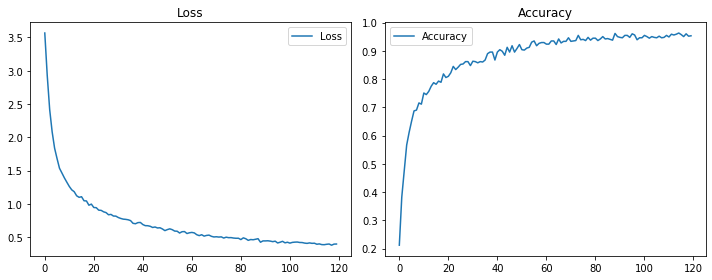

In [218]:
X1 = X.reshape(X_train.shape[0], 1, dim)
XT1 = x_teste.reshape(x_teste.shape[0], 1, dim)
Y1 = pd.get_dummies(Y)

# optimizer = Adam(lr=1e-3, amsgrad=True)
# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=1e-3)

nn = Sequential(name="Topic Modeling")
# nn.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=(1, dim), name="Conv_1"))
# nn.add(AveragePooling1D(1, stride=2, padding="same", name="AVG_POOLING_1"))
# nn.add(BatchNormalization())
# nn.add(Dropout(0.5, name="Dropout_1"))
nn.add(LSTM(256, input_shape=(1, dim), return_sequences=False, kernel_regularizer=regularizers.l2(1e-4), name="LSTM_1"))
nn.add(Dropout(0.5, name="Dropout_1"))
# nn.add(Dense(units=512, activation='relu', name="Dense_1", kernel_regularizer=regularizers.l2(1e-2)))
# nn.add(Dropout(0.5, name="Dropout_2"))
nn.add(Dense(units=42, activation='softmax', name="Output"))
nn.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
print(nn.summary())

history = nn.fit(X1, Y1, epochs=120, batch_size=32, shuffle=True, verbose=False)

y_pred = np.argmax(nn.predict(XT1, batch_size=32), axis=1)
print("Accuracy:", np.round(np.mean(y_pred == y_test) * 100, 2))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history["loss"], label="Loss")
# plt.plot(history.history["val_loss"], label="Val. Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], label="Accuracy", c="C0")
# plt.plot(history.history["val_accuracy"], label="Val. Accuracy", c="C1")
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X = scaler.fit_transform(d2v.docvecs.vectors_docs)
x_teste = np.array([d2v.infer_vector(tokenizer(doc), epochs=M) for doc in X_test])
x_teste = scaler.transform(x_teste)
Y = y_train

In [220]:
clf = LogisticRegressionCV(cv=3, random_state=0, multi_class='multinomial', n_jobs=4).fit(X, Y)
print("Accuracy:", np.round(clf.score(x_teste, y_test) * 100, 2))

Accuracy: 52.81


In [221]:
clf = RidgeClassifierCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, 1e-1]).fit(X, Y)
print("Accuracy:", np.round(clf.score(x_teste, y_test) * 100, 2))

Accuracy: 49.44


In [222]:
clf = SVC(C=50, kernel="rbf", random_state=0).fit(X, Y)
print("Accuracy:", np.round(clf.score(x_teste, y_test) * 100, 2))

clf = SVC(C=50, kernel="linear", random_state=0).fit(X, Y)
print("Accuracy:", np.round(clf.score(x_teste, y_test) * 100, 2))

Accuracy: 52.25
Accuracy: 50.56


In [223]:
clf1 = SVC(C=50, kernel="rbf", random_state=0)
clf2 = LogisticRegressionCV(cv=3, random_state=0, multi_class='multinomial', n_jobs=-1)
clf3 = RidgeClassifierCV(cv=3, alphas=[1e-4, 1e-3, 1e-2, 1e-1])

eclf = VotingClassifier(estimators=[
    ('svm', clf1),
    ('logistic', clf2),
    ('ridge', clf3),
], voting="hard", n_jobs=-1)
eclf = eclf.fit(X, Y)

print("Accuracy:", np.round(eclf.score(x_teste, y_test) * 100, 2))

Accuracy: 56.74


In [387]:
Y = d2v.docvecs.vectors_docs

clustering = KMeans(n_clusters=clusters, init='k-means++', max_iter=500, n_init=1).fit(1 - cosine_similarity(Y))

# kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
# assigned_clusters = kclusterer.cluster(Y, assign_clusters=True)
# assigned_clusters = np.array(assigned_clusters).ravel()

In [388]:
# a,b,c = 0,0,0
# for i in range(clusters):
#     unq, cnt = np.unique(assigned_clusters[assigned_clusters == i], return_counts=True)
#     print(f"Cluster {i}:", np.sum(y_train == i), cnt[0], np.abs(np.sum(y_train == i) - cnt[0]))
#     a += np.sum(y_train == i)
#     b += cnt[0]
#     c += cnt[0] - np.sum(y_train == i) if cnt[0] > np.sum(y_train == i) else 0
#     idx = np.where(y_train == i)
#     unq, cnt = np.unique(assigned_clusters[idx], return_counts=True)
#     cl = unq[np.where(cnt == np.max(cnt))][0]
# print(a, b, c)
# print(np.round(100 - (c/a*100), 2))

In [389]:
a,b,c = 0,0,0
for i in range(clusters):
    unq, cnt = np.unique(clustering.labels_[clustering.labels_ == i], return_counts=True)
    print(f"Cluster {i}:", np.sum(y_train == i), cnt[0], np.abs(np.sum(y_train == i) - cnt[0]))
    a += np.sum(y_train == i)
    b += cnt[0]
    c += cnt[0] - np.sum(y_train == i) if cnt[0] > np.sum(y_train == i) else 0
    idx = np.where(y_train == i)
    unq, cnt = np.unique(clustering.labels_[idx], return_counts=True)
    cl = unq[np.where(cnt == np.max(cnt))][0]
print(a, b, c)
print(np.round(100 - (c/a*100), 2))

Cluster 0: 18 10 8
Cluster 1: 17 16 1
Cluster 2: 12 20 8
Cluster 3: 14 15 1
Cluster 4: 18 8 10
Cluster 5: 16 19 3
Cluster 6: 31 19 12
Cluster 7: 28 23 5
Cluster 8: 13 22 9
Cluster 9: 18 16 2
Cluster 10: 14 23 9
Cluster 11: 15 24 9
Cluster 12: 9 9 0
Cluster 13: 17 24 7
Cluster 14: 17 24 7
Cluster 15: 17 14 3
Cluster 16: 14 15 1
Cluster 17: 19 19 0
Cluster 18: 25 16 9
Cluster 19: 21 18 3
Cluster 20: 20 16 4
Cluster 21: 15 11 4
Cluster 22: 17 18 1
Cluster 23: 17 17 0
Cluster 24: 15 20 5
Cluster 25: 16 14 2
Cluster 26: 15 19 4
Cluster 27: 14 23 9
Cluster 28: 16 11 5
Cluster 29: 15 20 5
Cluster 30: 17 24 7
Cluster 31: 19 14 5
Cluster 32: 19 15 4
Cluster 33: 14 12 2
Cluster 34: 18 13 5
Cluster 35: 20 15 5
Cluster 36: 15 11 4
Cluster 37: 17 21 4
Cluster 38: 16 11 5
Cluster 39: 17 17 0
Cluster 40: 13 19 6
Cluster 41: 13 16 3
711 711 98
86.22


In [366]:
# kpca = KernelPCA(n_components=3, kernel="linear", random_state=0, n_jobs=-1)
# Y = kpca.fit_transform(d2v.docvecs.vectors_docs)
mds = MDS(n_components=3, n_init=5, dissimilarity="precomputed", random_state=0, n_jobs=-1)
Y = mds.fit_transform(1 - cosine_similarity(d2v.docvecs.vectors_docs))

In [369]:
clustering = KMeans(n_clusters=clusters, init='k-means++', max_iter=500, n_init=1).fit(Y)

# kclusterer = KMeansClusterer(clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
# assigned_clusters = kclusterer.cluster(Y, assign_clusters=True)
# assigned_clusters = np.array(assigned_clusters).ravel()

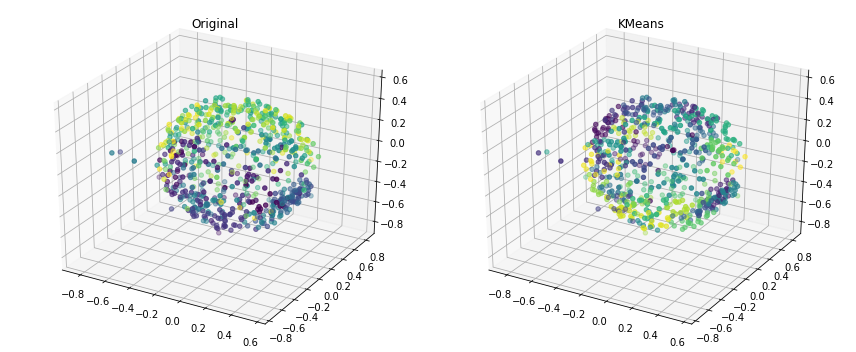

In [376]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1, projection='3d')
plt.title("Original")
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=y_train)
ax = plt.subplot(1, 2, 2, projection='3d')
plt.title("KMeans")
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=clustering.labels_)
# ax = plt.subplot(3, 1, 3, projection='3d')
# plt.title("KMeans : Cosine distante")
# ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=assigned_clusters)
plt.tight_layout()
plt.show()